In [82]:
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import math

import pandas as pd

import scipy.integrate as integrate
import scipy.special as sp
import scipy.optimize as spop
import scipy.ndimage.filters as filters



## Generative model

The model is represented by a 2D Gaussian, with random peak amplitude, width and position.

We thus start by defining the 2D Gaussian function:

In [30]:
def gaussian_2d(x, y, center_x, center_y, amplitude, sigma_x, sigma_y):
    return amplitude*np.exp(-(x-center_x)**2/(2*sigma_x**2))*np.exp(-(y-center_y)**2/(2*sigma_y**2))    

In [77]:
def background(image_size,offset,scattered_light):
    N=image_size
    return np.add([[np.random.poisson(scattered_light) for i in range(N)] for j in range(N)],offset)

We next define the model:

In [78]:
def model(x, y, center_x, center_y, amplitude, sigma_x, sigma_y):
    return gaussian_2d(x, y, center_x, center_y, amplitude, sigma_x, sigma_y)

In [79]:
x=np.linspace(1,250,250)
y=np.linspace(1,250,250)
x,y=np.meshgrid(x, y)

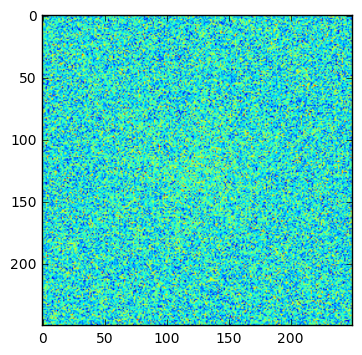

In [93]:
image=model(x,y,125,125,1,30,30)+background(250,0,10)
plt.imshow(image)

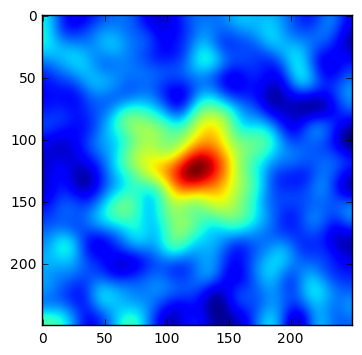

In [94]:
plt.imshow(filters.gaussian_filter(image,10))